# MLP Trained on the Fashion-MNIST Dataset Using Tensorflow

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Rescaling
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

import wandb
from wandb.keras import WandbCallback

from matplotlib import pyplot as plt

from pprint import pprint

## Login to Wandb

In [2]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Load Fashion-MNIST

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## Plot some examples

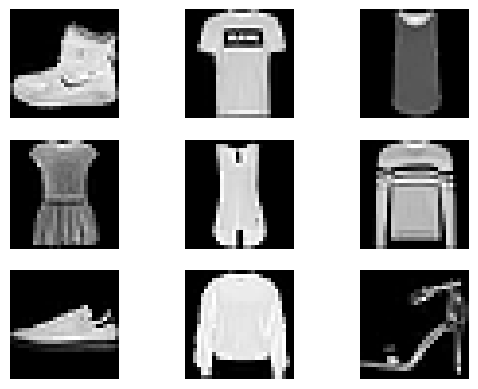

In [5]:
i = 0

for picture in x_train[:9]:
    plt.subplot(3, 3, i+1)
    plt.imshow(picture, cmap='gray')
    plt.axis('off')
    i = i + 1

plt.show()

## Define function for MLP creation

In [6]:
def create_model(config):
    model = Sequential([
        Rescaling(scale=1./255, input_shape=(28, 28)),
        Flatten(),
        
        Dense(config.dense_1, activation='relu'),
        Dense(config.dense_2, activation='relu'),
        Dense(config.dense_3, activation='relu'),
        Dense(config.dense_4, activation='relu'),

        Dense(10, activation='softmax'),
    ])

    return model

## Define function for model compilation

In [7]:
def compile_model(model, config):
    model.compile(
        optimizer=SGD(learning_rate=config.learning_rate, momentum=config.momentum),
        loss=SparseCategoricalCrossentropy(),
        metrics=[SparseCategoricalAccuracy()]
    )

## Define function for model training

In [8]:
def train_model(model, config, x_train, y_train):
    history = model.fit(
        x_train,
        y_train,
        epochs=config.epochs,
        validation_split=0.2,
        batch_size=config.batch_size,
        shuffle=True,
        callbacks=[
            WandbCallback()
        ]
    )

    return history

## Define sweep agent function

In [9]:
def sweep_train():
    default_config = {
        'dense_1': 512,
        'dense_2': 256,
        'dense_3': 256,
        'dense_4': 64,
        'learning_rate': 0.001,
        'momentum': 0.0,
        'epochs': 200,
        'batch_size': 128,
    }

    wandb.init(config=default_config)

    config = wandb.config

    mlp = create_model(config)
    mlp.summary()
    compile_model(mlp, config)
    _ = train_model(mlp, config, x_train, y_train)

## Configure Wandb Sweep for hyperparameter tuning

In [10]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'early_terminate':{
        'type': 'hyperband',
        'min_iter': 2
    },
    'parameters': {
        'batch_size': {
            'values': [16, 32, 64, 128, 256]
        },
        'epochs': {
            'min': 20,
            'max': 200
        },
        'learning_rate': {
            'min': 0.0001,
            'max': 0.1
        },
        'momentum': {
            'min': 0.0,
            'max': 0.9
        },
        'dense_1': {
            'min': 256,
            'max': 512
        },
        'dense_2': {
            'min': 128,
            'max': 256
        },
        'dense_3': {
            'min': 128,
            'max': 256
        },
        'dense_4': {
            'min': 32,
            'max': 64
        }
    }
}

pprint(sweep_config)

sweep_id = wandb.sweep(sweep_config, project='tf_mlp')

{'early_terminate': {'min_iter': 2, 'type': 'hyperband'},
 'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'val_loss'},
 'parameters': {'batch_size': {'values': [16, 32, 64, 128, 256]},
                'dense_1': {'max': 512, 'min': 256},
                'dense_2': {'max': 256, 'min': 128},
                'dense_3': {'max': 256, 'min': 128},
                'dense_4': {'max': 64, 'min': 32},
                'epochs': {'max': 200, 'min': 20},
                'learning_rate': {'max': 0.1, 'min': 0.0001},
                'momentum': {'max': 0.9, 'min': 0.0}}}
Create sweep with ID: ez31t9fh
Sweep URL: https://wandb.ai/nsiete23/tf_mlp/sweeps/ez31t9fh


## Run sweep

In [11]:
wandb.agent(sweep_id, function=sweep_train, count=50)

wandb: Agent Starting Run: xyyj8qvp with config:
wandb: 	batch_size: 16
wandb: 	dense_1: 435
wandb: 	dense_2: 161
wandb: 	dense_3: 235
wandb: 	dense_4: 50
wandb: 	epochs: 182
wandb: 	learning_rate: 0.06632727294564489
wandb: 	momentum: 0.6895146246744612
wandb: Currently logged in as: v-modroczky (nsiete23). Use `wandb login --relogin` to force relogin


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 435)               341475    
                                                                 
 dense_1 (Dense)             (None, 161)               70196     
                                                                 
 dense_2 (Dense)             (None, 235)               38070     
                                                                 
 dense_3 (Dense)             (None, 50)                11800     
                                                                 
 dense_4 (Dense)             (None, 10)                5

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/182
3000/3000 [==============================] - 14s 4ms/step - loss: 0.5902 - sparse_categorical_accuracy: 0.7838 - val_loss: 0.4572 - val_sparse_categorical_accuracy: 0.8346 - _timestamp: 1677329396.0000 - _runtime: 34.0000
Epoch 2/182
3000/3000 [==============================] - 11s 4ms/step - loss: 0.4372 - sparse_categorical_accuracy: 0.8414 - val_loss: 0.4221 - val_sparse_categorical_accuracy: 0.8451 - _timestamp: 1677329408.0000 - _runtime: 46.0000
Epoch 3/182
3000/3000 [==============================] - 11s 4ms/step - loss: 0.3922 - sparse_categorical_accuracy: 0.8574 - val_loss: 0.3735 - val_sparse_categorical_accuracy: 0.8662 - _timestamp: 1677329419.0000 - _runtime: 57.0000
Epoch 4/182
3000/3000 [==============================] - 8s 3ms/step - loss: 0.3697 - sparse_categorical_accuracy: 0.8643 - val_loss: 0.3917 - val_sparse_categorical_accuracy: 0.8524 - _timestamp: 1677329427.0000 - _runtime: 65.0000
Epoch 5/182
3000/3000 [==============================] - 8s 3ms/s

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███████████████████████
sparse_categorical_accuracy,▇████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁███████████████████████
val_sparse_categorical_accuracy,█████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
GFLOPS,0.00046
best_epoch,13
best_val_loss,0.34155
epoch,181
loss,2.30566
sparse_categorical_accuracy,0.10004


wandb: Agent Starting Run: pzhneszj with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 421
wandb: 	dense_2: 195
wandb: 	dense_3: 169
wandb: 	dense_4: 54
wandb: 	epochs: 111
wandb: 	learning_rate: 0.04043133103131728
wandb: 	momentum: 0.385363740344545


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 421)               330485    
                                                                 
 dense_1 (Dense)             (None, 195)               82290     
                                                                 
 dense_2 (Dense)             (None, 169)               33124     
                                                                 
 dense_3 (Dense)             (None, 54)                9180      
                                                                 
 dense_4 (Dense)             (None, 10)                5

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
val_loss,▃▂▁▁▁▁▁▁▂▂▂▂▃▂▃▃▃▄▄▄▅▄▄▅▅▆▇▅▇▇▆▆▇▇▇█▇▇▇█
val_sparse_categorical_accuracy,▁▃▅▅▆▆▆▆▆▇▆▇▇▇▅█▇▇▇█▆▇▇▇▇▇▅▇▆▇▇███▇▆▇▇▇█
GFLOPS,0.00046
best_epoch,11
best_val_loss,0.3149
epoch,110
loss,0.01664
sparse_categorical_accuracy,0.99425


wandb: Agent Starting Run: ngqzuwh3 with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 261
wandb: 	dense_2: 162
wandb: 	dense_3: 150
wandb: 	dense_4: 46
wandb: 	epochs: 53
wandb: 	learning_rate: 0.05678496549882092
wandb: 	momentum: 0.4646076720706829


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 261)               204885    
                                                                 
 dense_1 (Dense)             (None, 162)               42444     
                                                                 
 dense_2 (Dense)             (None, 150)               24450     
                                                                 
 dense_3 (Dense)             (None, 46)                6946      
                                                                 
 dense_4 (Dense)             (None, 10)                4

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████
val_loss,▆▅▃▂▃▂▂▁▁▁▁▂▂▁▂▂▄▂▃▄▃▃▅▄▃▃▅▆▅▅▆▇██▇██▇▇▇
val_sparse_categorical_accuracy,▁▂▅▆▅▆▆▇▇▇█▇▇█▇▇▇▇▇▇▇██▇███▇██▇▇▆▇▇▇▇█▇█
GFLOPS,0.00028
best_epoch,17
best_val_loss,0.31094
epoch,52
loss,0.0826
sparse_categorical_accuracy,0.96873


wandb: Agent Starting Run: 0rm9bknt with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 260
wandb: 	dense_2: 172
wandb: 	dense_3: 164
wandb: 	dense_4: 48
wandb: 	epochs: 33
wandb: 	learning_rate: 0.04707510303400909
wandb: 	momentum: 0.3187677066121812


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 260)               204100    
                                                                 
 dense_1 (Dense)             (None, 172)               44892     
                                                                 
 dense_2 (Dense)             (None, 164)               28372     
                                                                 
 dense_3 (Dense)             (None, 48)                7920      
                                                                 
 dense_4 (Dense)             (None, 10)                4

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_loss,█▅▅▄▃▃▂▃▃▂▄▃▂▂▂▂▂▁▂▁▁▂▂▁▂▁▁▂▂▁▂▂▂
val_sparse_categorical_accuracy,▁▅▄▅▆▆▇▆▆▇▅▇▇▇▇▇▇▇▇██▇▇█▇██▇▇█▇██
GFLOPS,0.00029
best_epoch,23
best_val_loss,0.30719
epoch,32
loss,0.19462
sparse_categorical_accuracy,0.92783


wandb: Agent Starting Run: klvla3cp with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 288
wandb: 	dense_2: 210
wandb: 	dense_3: 141
wandb: 	dense_4: 44
wandb: 	epochs: 90
wandb: 	learning_rate: 0.03908744842140242
wandb: 	momentum: 0.2076607786423501


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 288)               226080    
                                                                 
 dense_1 (Dense)             (None, 210)               60690     
                                                                 
 dense_2 (Dense)             (None, 141)               29751     
                                                                 
 dense_3 (Dense)             (None, 44)                6248      
                                                                 
 dense_4 (Dense)             (None, 10)                4

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
val_loss,█▄▃▃▂▂▃▂▂▁▂▁▁▂▁▃▂▂▂▁▃▂▁▂▄▂▄▂▂▁▂▂▂▂▃▄▃▃▃▃
val_sparse_categorical_accuracy,▁▄▆▆▆▇▆▇▆▇▇▇█▇█▆▇▇▇▇▆▇█▇▇▇▆███▇███▇▇▇███
GFLOPS,0.00032
best_epoch,30
best_val_loss,0.31956
epoch,89
loss,0.08835
sparse_categorical_accuracy,0.96946


wandb: Agent Starting Run: dr7q4usm with config:
wandb: 	batch_size: 32
wandb: 	dense_1: 325
wandb: 	dense_2: 256
wandb: 	dense_3: 130
wandb: 	dense_4: 64
wandb: 	epochs: 38
wandb: 	learning_rate: 0.029194537256771475
wandb: 	momentum: 0.06801558582772417


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 325)               255125    
                                                                 
 dense_1 (Dense)             (None, 256)               83456     
                                                                 
 dense_2 (Dense)             (None, 130)               33410     
                                                                 
 dense_3 (Dense)             (None, 64)                8384      
                                                                 
 dense_4 (Dense)             (None, 10)                6

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
val_loss,█▆▅▅▃▂▂▁▂▃▃▃▂▂▂▁▁▃▂▄▂▄▃▂▃▄▄▃▂▄▄▅▅▅▅▅▅▆
val_sparse_categorical_accuracy,▁▂▂▃▅▅▅▆▅▆▅▆▆▆▇▇▇▆▇▅▇▆▇▇▇▆▆████▇██▇▇█▇
GFLOPS,0.00038
best_epoch,16
best_val_loss,0.31108
epoch,37
loss,0.10154
sparse_categorical_accuracy,0.961


wandb: Agent Starting Run: u79hzqxb with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 352
wandb: 	dense_2: 167
wandb: 	dense_3: 134
wandb: 	dense_4: 49
wandb: 	epochs: 23
wandb: 	learning_rate: 0.02032816910976924
wandb: 	momentum: 0.13978395141778943


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 352)               276320    
                                                                 
 dense_1 (Dense)             (None, 167)               58951     
                                                                 
 dense_2 (Dense)             (None, 134)               22512     
                                                                 
 dense_3 (Dense)             (None, 49)                6615      
                                                                 
 dense_4 (Dense)             (None, 10)                5

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██████
val_loss,█▆▆▄▄▅▃▂▃▃▁▂▂▁▁▂▂▁▁▂▁▁▁
val_sparse_categorical_accuracy,▁▃▂▅▅▂▆▆▅▆▇▆▇▇▇▇▇▇█▇███
GFLOPS,0.00036
best_epoch,14
best_val_loss,0.30706
epoch,22
loss,0.20661
sparse_categorical_accuracy,0.92394


wandb: Agent Starting Run: f9soi15y with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 454
wandb: 	dense_2: 235
wandb: 	dense_3: 136
wandb: 	dense_4: 44
wandb: 	epochs: 22
wandb: 	learning_rate: 0.04972077258764452
wandb: 	momentum: 0.3441372260786411


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 454)               356390    
                                                                 
 dense_1 (Dense)             (None, 235)               106925    
                                                                 
 dense_2 (Dense)             (None, 136)               32096     
                                                                 
 dense_3 (Dense)             (None, 44)                6028      
                                                                 
 dense_4 (Dense)             (None, 10)                4

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇██████
val_loss,█▅▄▄▃▃▂▂▂▃▁▁▁▂▁▃▁▂▁▁▁▃
val_sparse_categorical_accuracy,▁▃▄▄▆▆▆▇▆▅▇▇▇▇▇▆██▇██▇
GFLOPS,0.0005
best_epoch,18
best_val_loss,0.31097
epoch,21
loss,0.17643
sparse_categorical_accuracy,0.93498


wandb: Agent Starting Run: rt8gu5gf with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 268
wandb: 	dense_2: 205
wandb: 	dense_3: 136
wandb: 	dense_4: 57
wandb: 	epochs: 22
wandb: 	learning_rate: 0.005480432271328497
wandb: 	momentum: 0.6852634989592119


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 268)               210380    
                                                                 
 dense_1 (Dense)             (None, 205)               55145     
                                                                 
 dense_2 (Dense)             (None, 136)               28016     
                                                                 
 dense_3 (Dense)             (None, 57)                7809      
                                                                 
 dense_4 (Dense)             (None, 10)                5

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▆▇▇▇▇▇▇▇████████████
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_sparse_categorical_accuracy,▁▄▅▅▆▆▆▇▆▇▇▇▇▇▇▇▆█████
GFLOPS,0.0003
best_epoch,20
best_val_loss,0.37455
epoch,21
loss,0.34315
sparse_categorical_accuracy,0.87727


wandb: Agent Starting Run: hphleh4c with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 272
wandb: 	dense_2: 164
wandb: 	dense_3: 160
wandb: 	dense_4: 64
wandb: 	epochs: 38
wandb: 	learning_rate: 0.0009444200911188911
wandb: 	momentum: 0.016950994454044244


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 272)               213520    
                                                                 
 dense_1 (Dense)             (None, 164)               44772     
                                                                 
 dense_2 (Dense)             (None, 160)               26400     
                                                                 
 dense_3 (Dense)             (None, 64)                10304     
                                                                 
 dense_4 (Dense)             (None, 10)                6

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████████████████
val_loss,█▇▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_sparse_categorical_accuracy,▁▃▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████
GFLOPS,0.0003
best_epoch,37
best_val_loss,0.49827
epoch,37
loss,0.49049
sparse_categorical_accuracy,0.83108


wandb: Agent Starting Run: mun248w8 with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 316
wandb: 	dense_2: 199
wandb: 	dense_3: 132
wandb: 	dense_4: 45
wandb: 	epochs: 23
wandb: 	learning_rate: 0.013798399262589049
wandb: 	momentum: 0.31150928790525734


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 316)               248060    
                                                                 
 dense_1 (Dense)             (None, 199)               63083     
                                                                 
 dense_2 (Dense)             (None, 132)               26400     
                                                                 
 dense_3 (Dense)             (None, 45)                5985      
                                                                 
 dense_4 (Dense)             (None, 10)                4

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▆▆▇▇▇▇▇▇▇▇███████████
val_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂
val_sparse_categorical_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇████████▇
GFLOPS,0.00034
best_epoch,21
best_val_loss,0.36224
epoch,22
loss,0.3251
sparse_categorical_accuracy,0.88375


wandb: Agent Starting Run: 3fg25yau with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 434
wandb: 	dense_2: 177
wandb: 	dense_3: 136
wandb: 	dense_4: 59
wandb: 	epochs: 33
wandb: 	learning_rate: 0.06508085573287967
wandb: 	momentum: 0.09281597423042869


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 434)               340690    
                                                                 
 dense_1 (Dense)             (None, 177)               76995     
                                                                 
 dense_2 (Dense)             (None, 136)               24208     
                                                                 
 dense_3 (Dense)             (None, 59)                8083      
                                                                 
 dense_4 (Dense)             (None, 10)                6

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_loss,█▇▆▄▅▄▄▄▃▃▃▂▂▂▂▂▁▂▂▂▂▂▅▃▁▂▂▁▄▂▂▂▂
val_sparse_categorical_accuracy,▁▁▃▄▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▄▆██▇█▅▇███
GFLOPS,0.00045
best_epoch,27
best_val_loss,0.30325
epoch,32
loss,0.18492
sparse_categorical_accuracy,0.9315


wandb: Agent Starting Run: jnx4fd3u with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 459
wandb: 	dense_2: 256
wandb: 	dense_3: 138
wandb: 	dense_4: 36
wandb: 	epochs: 46
wandb: 	learning_rate: 0.09843135672173992
wandb: 	momentum: 0.07715348543359757


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 459)               360315    
                                                                 
 dense_1 (Dense)             (None, 256)               117760    
                                                                 
 dense_2 (Dense)             (None, 138)               35466     
                                                                 
 dense_3 (Dense)             (None, 36)                5004      
                                                                 
 dense_4 (Dense)             (None, 10)                3

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▄▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇█▇██████
val_loss,█▅▃▅▃▅▂▃▂▂▁▃▂▃▂▂▂▂▁▂▃▁▂▃▃▂▂▁▂▂▁▂▁▅▃▂▂▂▂▂
val_sparse_categorical_accuracy,▁▄▅▄▆▄▆▆▇▆▇▆▇▅▆▆▇▇▇▇▆▇▇▆▆▇▇█▇▇█▇█▅▇█████
GFLOPS,0.00052
best_epoch,31
best_val_loss,0.3126
epoch,45
loss,0.13054
sparse_categorical_accuracy,0.95144


wandb: Agent Starting Run: 4rvbtdtq with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 256
wandb: 	dense_2: 201
wandb: 	dense_3: 131
wandb: 	dense_4: 59
wandb: 	epochs: 31
wandb: 	learning_rate: 0.03591179767412824
wandb: 	momentum: 0.2837624532277976


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 201)               51657     
                                                                 
 dense_2 (Dense)             (None, 131)               26462     
                                                                 
 dense_3 (Dense)             (None, 59)                7788      
                                                                 
 dense_4 (Dense)             (None, 10)                6

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
val_loss,█▅▅▄▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▃▁▁▁▁▂▁
val_sparse_categorical_accuracy,▁▄▄▅▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇██▇▇█▆████▇█
GFLOPS,0.00029
best_epoch,23
best_val_loss,0.31558
epoch,30
loss,0.22804
sparse_categorical_accuracy,0.91615


wandb: Agent Starting Run: 6omnh8j5 with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 333
wandb: 	dense_2: 160
wandb: 	dense_3: 134
wandb: 	dense_4: 35
wandb: 	epochs: 28
wandb: 	learning_rate: 0.05142819166420097
wandb: 	momentum: 0.039338328258310455


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 333)               261405    
                                                                 
 dense_1 (Dense)             (None, 160)               53440     
                                                                 
 dense_2 (Dense)             (None, 134)               21574     
                                                                 
 dense_3 (Dense)             (None, 35)                4725      
                                                                 
 dense_4 (Dense)             (None, 10)                3

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
val_loss,█▆▄▄▃▂▃▂▃▂▂▂▂▂▁▂▂▂▂▂▁▂▁▂▂▁▂▁
val_sparse_categorical_accuracy,▁▃▅▅▆▆▆▇▆▇▇▇▇▇█▇▇▇███▇█▆▇███
GFLOPS,0.00034
best_epoch,20
best_val_loss,0.30792
epoch,27
loss,0.17822
sparse_categorical_accuracy,0.93388


wandb: Agent Starting Run: ac1kd2pu with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 259
wandb: 	dense_2: 243
wandb: 	dense_3: 131
wandb: 	dense_4: 53
wandb: 	epochs: 32
wandb: 	learning_rate: 0.06776463877571881
wandb: 	momentum: 0.08238000345513351


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 259)               203315    
                                                                 
 dense_1 (Dense)             (None, 243)               63180     
                                                                 
 dense_2 (Dense)             (None, 131)               31964     
                                                                 
 dense_3 (Dense)             (None, 53)                6996      
                                                                 
 dense_4 (Dense)             (None, 10)                5

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████
val_loss,██▇▄▄▃▄▃▃▂▆▂▃▂▂▂▁▂▂▁▂▁▂▂▁▂▂▂▂▂▂▂
val_sparse_categorical_accuracy,▂▁▃▅▅▆▅▆▆▆▃▇▆▇▆▇█▇▇▇▇▇▇▇█▇▇▇█▇▇█
GFLOPS,0.00031
best_epoch,16
best_val_loss,0.30001
epoch,31
loss,0.1502
sparse_categorical_accuracy,0.94288


wandb: Agent Starting Run: e1n76wd5 with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 256
wandb: 	dense_2: 203
wandb: 	dense_3: 156
wandb: 	dense_4: 57
wandb: 	epochs: 20
wandb: 	learning_rate: 0.09845593340631292
wandb: 	momentum: 0.626478602802149


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 203)               52171     
                                                                 
 dense_2 (Dense)             (None, 156)               31824     
                                                                 
 dense_3 (Dense)             (None, 57)                8949      
                                                                 
 dense_4 (Dense)             (None, 10)                5

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▆▇▇▇▇▇▇▇██████
val_loss,█▇▆▄▄▃▃▅▂▂▁▂▂▁▃▂▁▂▂▂
val_sparse_categorical_accuracy,▁▁▂▅▄▆▅▃▆▆▇▇▇▇▆▇█▇▇█
GFLOPS,0.00029
best_epoch,10
best_val_loss,0.31118
epoch,19
loss,0.18848
sparse_categorical_accuracy,0.92821


wandb: Agent Starting Run: 9qk5hufp with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 434
wandb: 	dense_2: 207
wandb: 	dense_3: 130
wandb: 	dense_4: 57
wandb: 	epochs: 53
wandb: 	learning_rate: 0.03494297644662809
wandb: 	momentum: 0.28371875814936176


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 434)               340690    
                                                                 
 dense_1 (Dense)             (None, 207)               90045     
                                                                 
 dense_2 (Dense)             (None, 130)               27040     
                                                                 
 dense_3 (Dense)             (None, 57)                7467      
                                                                 
 dense_4 (Dense)             (None, 10)                5

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
val_loss,█▅▅▅▃▃▂▂▂▂▂▂▁▂▂▂▂▁▁▄▂▃▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▁▂▂
val_sparse_categorical_accuracy,▁▄▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▅▇▆██████▇███████▇██▇
GFLOPS,0.00047
best_epoch,34
best_val_loss,0.30396
epoch,52
loss,0.13628
sparse_categorical_accuracy,0.94983


wandb: Agent Starting Run: bjofpn7x with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 424
wandb: 	dense_2: 255
wandb: 	dense_3: 129
wandb: 	dense_4: 59
wandb: 	epochs: 38
wandb: 	learning_rate: 0.0974697837205256
wandb: 	momentum: 0.1524150129926103


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 424)               332840    
                                                                 
 dense_1 (Dense)             (None, 255)               108375    
                                                                 
 dense_2 (Dense)             (None, 129)               33024     
                                                                 
 dense_3 (Dense)             (None, 59)                7670      
                                                                 
 dense_4 (Dense)             (None, 10)                6

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▆▂▂▂
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████▅▇▇▇
val_loss,█▇▄▅▅▅▄▄▃▂▂▂▃▃▃▂▁▂▂▃▂▂▂▂▂▁▂▂▂▁▅▃▄▂▅▄▃▃
val_sparse_categorical_accuracy,▁▂▅▃▄▄▄▄▆▇▇▇▆▆▆▆▇▆▆▅▇▇▇▇▇█▇▇▇█▄▇▇█▅▅▆▇
GFLOPS,0.00048
best_epoch,25
best_val_loss,0.29806
epoch,37
loss,0.21126
sparse_categorical_accuracy,0.92073


wandb: Agent Starting Run: 7tpwuf16 with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 267
wandb: 	dense_2: 201
wandb: 	dense_3: 138
wandb: 	dense_4: 48
wandb: 	epochs: 29
wandb: 	learning_rate: 0.08955200190700374
wandb: 	momentum: 0.09207982247542816


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 267)               209595    
                                                                 
 dense_1 (Dense)             (None, 201)               53868     
                                                                 
 dense_2 (Dense)             (None, 138)               27876     
                                                                 
 dense_3 (Dense)             (None, 48)                6672      
                                                                 
 dense_4 (Dense)             (None, 10)                4

epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
val_loss,█▅▄▄▃▃▄▂▂▂▂▁▁▁▂▁▂▂▂▁▂▁▂▃▂▃▂▂▂
val_sparse_categorical_accuracy,▁▄▅▅▆▆▅▆▆▇▇▇█▇▇█▇▇▇█▇██▇█▇▇██
GFLOPS,0.0003
best_epoch,11
best_val_loss,0.30997
epoch,28
loss,0.15922
sparse_categorical_accuracy,0.93906


wandb: Agent Starting Run: 5w5hk9mt with config:
wandb: 	batch_size: 32
wandb: 	dense_1: 266
wandb: 	dense_2: 227
wandb: 	dense_3: 129
wandb: 	dense_4: 45
wandb: 	epochs: 21
wandb: 	learning_rate: 0.025239228542127224
wandb: 	momentum: 0.05562721880609916


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 266)               208810    
                                                                 
 dense_1 (Dense)             (None, 227)               60609     
                                                                 
 dense_2 (Dense)             (None, 129)               29412     
                                                                 
 dense_3 (Dense)             (None, 45)                5850      
                                                                 
 dense_4 (Dense)             (None, 10)                4

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇██████
val_loss,█▅▃▄▃▃▂▁▂▂▁▁▂▂▃▁▂▁▂▁▃
val_sparse_categorical_accuracy,▁▄▅▅▅▆▇▇▆▇▇▇▆▇▆█▇█▇█▆
GFLOPS,0.00031
best_epoch,10
best_val_loss,0.30869
epoch,20
loss,0.18145
sparse_categorical_accuracy,0.93117


wandb: Agent Starting Run: 3eq7ss0o with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 333
wandb: 	dense_2: 205
wandb: 	dense_3: 131
wandb: 	dense_4: 51
wandb: 	epochs: 30
wandb: 	learning_rate: 0.05474498069982207
wandb: 	momentum: 0.4030167458365599


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 333)               261405    
                                                                 
 dense_1 (Dense)             (None, 205)               68470     
                                                                 
 dense_2 (Dense)             (None, 131)               26986     
                                                                 
 dense_3 (Dense)             (None, 51)                6732      
                                                                 
 dense_4 (Dense)             (None, 10)                5

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████
val_loss,▇█▅▃▃▂▂▃▂▁▁▁▁▂▁▁▃▂▂▁▂▂▂▂▁▄▃▂▄▅
val_sparse_categorical_accuracy,▁▁▃▅▆▆▆▅▆▇▇▇▇▆▇▇▇█▇█▇████▇███▇
GFLOPS,0.00036
best_epoch,15
best_val_loss,0.31882
epoch,29
loss,0.12854
sparse_categorical_accuracy,0.95131


wandb: Agent Starting Run: vw28d712 with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 491
wandb: 	dense_2: 252
wandb: 	dense_3: 138
wandb: 	dense_4: 63
wandb: 	epochs: 29
wandb: 	learning_rate: 0.029197719493279463
wandb: 	momentum: 0.238103715649221


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 491)               385435    
                                                                 
 dense_1 (Dense)             (None, 252)               123984    
                                                                 
 dense_2 (Dense)             (None, 138)               34914     
                                                                 
 dense_3 (Dense)             (None, 63)                8757      
                                                                 
 dense_4 (Dense)             (None, 10)                6

epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
val_loss,█▆▅▆▃▄▃▃▃▃▃▄▂▂▂▂▂▂▂▂▂▃▁▁▁▁▂▁▁
val_sparse_categorical_accuracy,▁▃▅▃▆▅▆▆▆▆▆▅▇▆▇▇▇▆▇▇▇▆████▇██
GFLOPS,0.00055
best_epoch,25
best_val_loss,0.32045
epoch,28
loss,0.24184
sparse_categorical_accuracy,0.91246


wandb: Agent Starting Run: c6ygu0cc with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 308
wandb: 	dense_2: 165
wandb: 	dense_3: 138
wandb: 	dense_4: 64
wandb: 	epochs: 21
wandb: 	learning_rate: 0.07625159145193597
wandb: 	momentum: 0.6104169190292291


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 308)               241780    
                                                                 
 dense_1 (Dense)             (None, 165)               50985     
                                                                 
 dense_2 (Dense)             (None, 138)               22908     
                                                                 
 dense_3 (Dense)             (None, 64)                8896      
                                                                 
 dense_4 (Dense)             (None, 10)                6

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▆▇▇▇▇▇▇▇███████
val_loss,█▇▄▄▃▅▄▂▃▃▂▂▂▄▂▄▃▂▁▂▃
val_sparse_categorical_accuracy,▁▂▄▅▆▂▅▇▅▆▆▇▇▆▇▆▆▇█▇▇
GFLOPS,0.00033
best_epoch,18
best_val_loss,0.30741
epoch,20
loss,0.18828
sparse_categorical_accuracy,0.92827


wandb: Agent Starting Run: zxckxbzc with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 302
wandb: 	dense_2: 159
wandb: 	dense_3: 137
wandb: 	dense_4: 53
wandb: 	epochs: 21
wandb: 	learning_rate: 0.0725119101833033
wandb: 	momentum: 0.34107198439535874


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 302)               237070    
                                                                 
 dense_1 (Dense)             (None, 159)               48177     
                                                                 
 dense_2 (Dense)             (None, 137)               21920     
                                                                 
 dense_3 (Dense)             (None, 53)                7314      
                                                                 
 dense_4 (Dense)             (None, 10)                5

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇██████
val_loss,█▆▄▄▄▅▃▃▅▂▁▃▂▂▂▂▃▁▁▂▃
val_sparse_categorical_accuracy,▁▄▄▅▅▂▆▆▄▇▇▆▆▇▇▇▆██▇▇
GFLOPS,0.00032
best_epoch,18
best_val_loss,0.30827
epoch,20
loss,0.21814
sparse_categorical_accuracy,0.91898


wandb: Agent Starting Run: 2dcznnfo with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 486
wandb: 	dense_2: 186
wandb: 	dense_3: 132
wandb: 	dense_4: 51
wandb: 	epochs: 33
wandb: 	learning_rate: 0.04259164184039747
wandb: 	momentum: 0.07989187100791889


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 486)               381510    
                                                                 
 dense_1 (Dense)             (None, 186)               90582     
                                                                 
 dense_2 (Dense)             (None, 132)               24684     
                                                                 
 dense_3 (Dense)             (None, 51)                6783      
                                                                 
 dense_4 (Dense)             (None, 10)                5

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
val_loss,█▅▅▃▃▂▃▂▂▃▂▂▁▁▁▂▂▂▂▂▂▂▃▂▃▂▅▃▃▃▄▅▃
val_sparse_categorical_accuracy,▁▄▄▆▅▆▆▆▇▅▇▇█▇█▆▇▇█▇█▇▆▇▇█▆█▇█▇▆█
GFLOPS,0.0005
best_epoch,12
best_val_loss,0.30392
epoch,32
loss,0.12272
sparse_categorical_accuracy,0.95294


wandb: Agent Starting Run: z845dfro with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 447
wandb: 	dense_2: 162
wandb: 	dense_3: 137
wandb: 	dense_4: 49
wandb: 	epochs: 28
wandb: 	learning_rate: 0.015162879101698562
wandb: 	momentum: 0.029386255802153628


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 447)               350895    
                                                                 
 dense_1 (Dense)             (None, 162)               72576     
                                                                 
 dense_2 (Dense)             (None, 137)               22331     
                                                                 
 dense_3 (Dense)             (None, 49)                6762      
                                                                 
 dense_4 (Dense)             (None, 10)                5

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████
val_loss,██▄▃▃▃▃▂▃▂▂▂▂▂▁▂▁▁▂▂▂▁▁▁▁▁▁▁
val_sparse_categorical_accuracy,▁▁▅▆▆▆▆▇▆▇▇▇▆▆█▇██▇▇▇██▇████
GFLOPS,0.00045
best_epoch,25
best_val_loss,0.36933
epoch,27
loss,0.32818
sparse_categorical_accuracy,0.8829


wandb: Agent Starting Run: fbw8uksn with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 488
wandb: 	dense_2: 229
wandb: 	dense_3: 134
wandb: 	dense_4: 61
wandb: 	epochs: 22
wandb: 	learning_rate: 0.06919129103691889
wandb: 	momentum: 0.04499494539561429


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 488)               383080    
                                                                 
 dense_1 (Dense)             (None, 229)               111981    
                                                                 
 dense_2 (Dense)             (None, 134)               30820     
                                                                 
 dense_3 (Dense)             (None, 61)                8235      
                                                                 
 dense_4 (Dense)             (None, 10)                6

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇███████
val_loss,█▆█▄▃▂▂▃▂▂▂▂▂▂▂▃▁▁▁▂▂▁
val_sparse_categorical_accuracy,▁▃▂▅▆▇▇▆▇▇▇▇▇▇▇▆███▇▇█
GFLOPS,0.00053
best_epoch,21
best_val_loss,0.31866
epoch,21
loss,0.23516
sparse_categorical_accuracy,0.91225


wandb: Agent Starting Run: kuemrjq0 with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 274
wandb: 	dense_2: 211
wandb: 	dense_3: 141
wandb: 	dense_4: 62
wandb: 	epochs: 53
wandb: 	learning_rate: 0.08465150891499948
wandb: 	momentum: 0.2400794932066453


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 274)               215090    
                                                                 
 dense_1 (Dense)             (None, 211)               58025     
                                                                 
 dense_2 (Dense)             (None, 141)               29892     
                                                                 
 dense_3 (Dense)             (None, 62)                8804      
                                                                 
 dense_4 (Dense)             (None, 10)                6

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▄
sparse_categorical_accuracy,▁▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████▄
val_loss,█▅▅▃▅▂▂▄▂▂▃▂▁▁▂▂▃▂▁▆▂▃▂▂▂▂▂▄▂▃▂▄▃▃▃▂▃▃▃▅
val_sparse_categorical_accuracy,▁▄▅▆▃▆▆▅▇▇▆▇▇█▇▇▇▇█▅▇▆▇▇▇██▇█▇█▇▇▇▇██▇█▄
GFLOPS,0.00031
best_epoch,17
best_val_loss,0.30718
epoch,52
loss,0.45811
sparse_categorical_accuracy,0.83283


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nbikgdqq with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 363
wandb: 	dense_2: 248
wandb: 	dense_3: 193
wandb: 	dense_4: 40
wandb: 	epochs: 32
wandb: 	learning_rate: 0.0010896170575092957
wandb: 	momentum: 0.013866501239276496


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 363)               284955    
                                                                 
 dense_1 (Dense)             (None, 248)               90272     
                                                                 
 dense_2 (Dense)             (None, 193)               48057     
                                                                 
 dense_3 (Dense)             (None, 40)                7760      
                                                                 
 dense_4 (Dense)             (None, 10)                4

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▃▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████
val_loss,█▇▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_sparse_categorical_accuracy,▁▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
GFLOPS,0.00043
best_epoch,31
best_val_loss,0.58875
epoch,31
loss,0.59547
sparse_categorical_accuracy,0.80008


wandb: Agent Starting Run: 8n41q47p with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 261
wandb: 	dense_2: 161
wandb: 	dense_3: 135
wandb: 	dense_4: 33
wandb: 	epochs: 51
wandb: 	learning_rate: 0.019157104490245824
wandb: 	momentum: 0.2509171977533043


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 261)               204885    
                                                                 
 dense_1 (Dense)             (None, 161)               42182     
                                                                 
 dense_2 (Dense)             (None, 135)               21870     
                                                                 
 dense_3 (Dense)             (None, 33)                4488      
                                                                 
 dense_4 (Dense)             (None, 10)                3

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_loss,█▇▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▄▂▂▁▂▁▁▂▁▁▁▁▁▂▂▁▁▂▂▁▂▁
val_sparse_categorical_accuracy,▁▂▅▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇▅▇██▇█████████▇███▇█▇█
GFLOPS,0.00027
best_epoch,43
best_val_loss,0.31299
epoch,50
loss,0.21593
sparse_categorical_accuracy,0.9224


wandb: Agent Starting Run: n35m7taw with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 274
wandb: 	dense_2: 132
wandb: 	dense_3: 129
wandb: 	dense_4: 32
wandb: 	epochs: 75
wandb: 	learning_rate: 0.03219627283112413
wandb: 	momentum: 0.03392275757498645


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 274)               215090    
                                                                 
 dense_1 (Dense)             (None, 132)               36300     
                                                                 
 dense_2 (Dense)             (None, 129)               17157     
                                                                 
 dense_3 (Dense)             (None, 32)                4160      
                                                                 
 dense_4 (Dense)             (None, 10)                3

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
val_loss,█▆▅▄▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▂▂▂▃▃▃▃▄▃▃▄▃▃
val_sparse_categorical_accuracy,▁▃▄▅▆▆▆▆▇▆▇▇▇▇▇▇▇███▇█▇████████▇██▇██▇██
GFLOPS,0.00027
best_epoch,23
best_val_loss,0.30928
epoch,74
loss,0.07817
sparse_categorical_accuracy,0.97175


wandb: Agent Starting Run: y2f5nwm1 with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 290
wandb: 	dense_2: 173
wandb: 	dense_3: 141
wandb: 	dense_4: 34
wandb: 	epochs: 28
wandb: 	learning_rate: 0.07472931615260575
wandb: 	momentum: 0.0862018266555328


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 290)               227650    
                                                                 
 dense_1 (Dense)             (None, 173)               50343     
                                                                 
 dense_2 (Dense)             (None, 141)               24534     
                                                                 
 dense_3 (Dense)             (None, 34)                4828      
                                                                 
 dense_4 (Dense)             (None, 10)                3

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
val_loss,██▄▃▃▅▃▂▂▃▂▃▂▁▃▂▁▂▂▁▂▂▁▁▁▄▁▁
val_sparse_categorical_accuracy,▂▁▅▆▆▅▅▇▇▅▇▅▇▇▆▇█▇▇▇▇▇███▆██
GFLOPS,0.00031
best_epoch,22
best_val_loss,0.31531
epoch,27
loss,0.20697
sparse_categorical_accuracy,0.92354


wandb: Agent Starting Run: iz3wd12h with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 279
wandb: 	dense_2: 240
wandb: 	dense_3: 138
wandb: 	dense_4: 50
wandb: 	epochs: 27
wandb: 	learning_rate: 0.04808001020446397
wandb: 	momentum: 0.8105856603288553


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 279)               219015    
                                                                 
 dense_1 (Dense)             (None, 240)               67200     
                                                                 
 dense_2 (Dense)             (None, 138)               33258     
                                                                 
 dense_3 (Dense)             (None, 50)                6950      
                                                                 
 dense_4 (Dense)             (None, 10)                5

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████
val_loss,█▄▄▃▃▂▂▂▂▃▃▁▂▁▂▂▂▂▁▁▂▂▂▁▃▃▂
val_sparse_categorical_accuracy,▁▄▅▆▆▇▇▇▇▆▆▇▇▇▇▇▇▇██████▇▇▇
GFLOPS,0.00033
best_epoch,19
best_val_loss,0.31291
epoch,26
loss,0.1518
sparse_categorical_accuracy,0.94229


wandb: Agent Starting Run: zbb5u7m9 with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 315
wandb: 	dense_2: 215
wandb: 	dense_3: 136
wandb: 	dense_4: 42
wandb: 	epochs: 28
wandb: 	learning_rate: 0.060344912078913696
wandb: 	momentum: 0.1395564589749933


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 315)               247275    
                                                                 
 dense_1 (Dense)             (None, 215)               67940     
                                                                 
 dense_2 (Dense)             (None, 136)               29376     
                                                                 
 dense_3 (Dense)             (None, 42)                5754      
                                                                 
 dense_4 (Dense)             (None, 10)                4

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
val_loss,█▆▄▅▄▃▃▂▂▂▂▁▁▂▂▁▃▂▂▁▂▃▁▂▂▂▂▂
val_sparse_categorical_accuracy,▁▃▅▄▅▅▅▇▆▇▇▇▇▇▇█▅▇▇▇▇▇█▇▇███
GFLOPS,0.00035
best_epoch,15
best_val_loss,0.30445
epoch,27
loss,0.16643
sparse_categorical_accuracy,0.93748


wandb: Agent Starting Run: w2brh09e with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 266
wandb: 	dense_2: 137
wandb: 	dense_3: 143
wandb: 	dense_4: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.06798034804599601
wandb: 	momentum: 0.8514288580149648


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 266)               208810    
                                                                 
 dense_1 (Dense)             (None, 137)               36579     
                                                                 
 dense_2 (Dense)             (None, 143)               19734     
                                                                 
 dense_3 (Dense)             (None, 32)                4608      
                                                                 
 dense_4 (Dense)             (None, 10)                3

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████
val_loss,█▄▃▂▃▂▃▂▁▁▂▂▁▁▁▁▁▂▂▂▃▁▂▃▂▃▂▃▂▂
val_sparse_categorical_accuracy,▁▅▅▆▅▆▆▆▇▇▇▇▇▇▇▇███▇▇▇█▇██████
GFLOPS,0.00027
best_epoch,15
best_val_loss,0.31841
epoch,29
loss,0.15462
sparse_categorical_accuracy,0.94179


wandb: Agent Starting Run: tr8gqxiq with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 256
wandb: 	dense_2: 234
wandb: 	dense_3: 168
wandb: 	dense_4: 35
wandb: 	epochs: 34
wandb: 	learning_rate: 0.06900444968668755
wandb: 	momentum: 0.429613014225271


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 234)               60138     
                                                                 
 dense_2 (Dense)             (None, 168)               39480     
                                                                 
 dense_3 (Dense)             (None, 35)                5915      
                                                                 
 dense_4 (Dense)             (None, 10)                3

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
val_loss,█▅▆▄▄▃▃▃▃▆▃▁▂▄▂▂▂▂▁▂▂▂▂▂▁▂▂▂▂▃▂▂▂▂
val_sparse_categorical_accuracy,▁▃▃▅▅▅▅▅▆▂▅▇▆▅▇▇▆▇▇▇▇▇▇▇█▇█▇█▆▇▇▇▇
GFLOPS,0.00031
best_epoch,18
best_val_loss,0.31446
epoch,33
loss,0.15797
sparse_categorical_accuracy,0.94231


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zr46h8tq with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 285
wandb: 	dense_2: 214
wandb: 	dense_3: 142
wandb: 	dense_4: 41
wandb: 	epochs: 26
wandb: 	learning_rate: 0.06644488970136565
wandb: 	momentum: 0.46975937556289415


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 285)               223725    
                                                                 
 dense_1 (Dense)             (None, 214)               61204     
                                                                 
 dense_2 (Dense)             (None, 142)               30530     
                                                                 
 dense_3 (Dense)             (None, 41)                5863      
                                                                 
 dense_4 (Dense)             (None, 10)                4

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
val_loss,█▆▅▄▃▄▃▂▂▃▂▂▂▁▁▂▃▅▁▁▂▁▃▁▂▄
val_sparse_categorical_accuracy,▁▂▄▅▆▅▅▆▇▆▇▆▇██▇▆▄████▇█▇▆
GFLOPS,0.00032
best_epoch,19
best_val_loss,0.3123
epoch,25
loss,0.1769
sparse_categorical_accuracy,0.93367


wandb: Agent Starting Run: 2sa04zmr with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 435
wandb: 	dense_2: 193
wandb: 	dense_3: 129
wandb: 	dense_4: 55
wandb: 	epochs: 20
wandb: 	learning_rate: 0.06018901011042956
wandb: 	momentum: 0.6340419836628446


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 435)               341475    
                                                                 
 dense_1 (Dense)             (None, 193)               84148     
                                                                 
 dense_2 (Dense)             (None, 129)               25026     
                                                                 
 dense_3 (Dense)             (None, 55)                7150      
                                                                 
 dense_4 (Dense)             (None, 10)                5

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇█████
val_loss,█▅▄▃▃▃▄▂▁▁▂▁▁▂▂▂▂▂▃▃
val_sparse_categorical_accuracy,▁▄▄▆▆▆▅▇▇▇▇██▇▇▇██▇▇
GFLOPS,0.00046
best_epoch,11
best_val_loss,0.30157
epoch,19
loss,0.17817
sparse_categorical_accuracy,0.93287


wandb: Agent Starting Run: u7auhstk with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 433
wandb: 	dense_2: 216
wandb: 	dense_3: 129
wandb: 	dense_4: 62
wandb: 	epochs: 20
wandb: 	learning_rate: 0.03398224440627504
wandb: 	momentum: 0.7451369648163401


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 433)               339905    
                                                                 
 dense_1 (Dense)             (None, 216)               93744     
                                                                 
 dense_2 (Dense)             (None, 129)               27993     
                                                                 
 dense_3 (Dense)             (None, 62)                8060      
                                                                 
 dense_4 (Dense)             (None, 10)                6

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇█████
val_loss,█▅▄▃▃▃▃▂▂▂▂▁▁▁▁▁▂▂▂▂
val_sparse_categorical_accuracy,▁▅▅▆▇▆▆▇▇▇▇█████▇▇█▇
GFLOPS,0.00047
best_epoch,12
best_val_loss,0.30759
epoch,19
loss,0.19678
sparse_categorical_accuracy,0.9259


wandb: Agent Starting Run: fat4zjc9 with config:
wandb: 	batch_size: 32
wandb: 	dense_1: 257
wandb: 	dense_2: 222
wandb: 	dense_3: 141
wandb: 	dense_4: 34
wandb: 	epochs: 21
wandb: 	learning_rate: 0.0776274876216844
wandb: 	momentum: 0.007943766993256185


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 257)               201745    
                                                                 
 dense_1 (Dense)             (None, 222)               57276     
                                                                 
 dense_2 (Dense)             (None, 141)               31443     
                                                                 
 dense_3 (Dense)             (None, 34)                4828      
                                                                 
 dense_4 (Dense)             (None, 10)                3

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇█████
val_loss,█▇▂▃▂▂▂▂▁▁▂▁▂▁▁▂▂▁▃▃▃
val_sparse_categorical_accuracy,▁▃▆▅▆▆▆▇▇▇▇▇▆▇▇▇██▇▇█
GFLOPS,0.0003
best_epoch,9
best_val_loss,0.32408
epoch,20
loss,0.17447
sparse_categorical_accuracy,0.93302


wandb: Agent Starting Run: ieb3h53m with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 298
wandb: 	dense_2: 218
wandb: 	dense_3: 171
wandb: 	dense_4: 35
wandb: 	epochs: 23
wandb: 	learning_rate: 0.0574201752222796
wandb: 	momentum: 0.0831262822023476


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 298)               233930    
                                                                 
 dense_1 (Dense)             (None, 218)               65182     
                                                                 
 dense_2 (Dense)             (None, 171)               37449     
                                                                 
 dense_3 (Dense)             (None, 35)                6020      
                                                                 
 dense_4 (Dense)             (None, 10)                3

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇████████
val_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▂▃▁▁▂▁▁▁▁▁
val_sparse_categorical_accuracy,▁▆▆▇▇▇▇▇▇▇███▇▇██▇███▇█
GFLOPS,0.00034
best_epoch,20
best_val_loss,0.30753
epoch,22
loss,0.2002
sparse_categorical_accuracy,0.9246


wandb: Agent Starting Run: z2wpjjw0 with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 345
wandb: 	dense_2: 242
wandb: 	dense_3: 140
wandb: 	dense_4: 58
wandb: 	epochs: 30
wandb: 	learning_rate: 0.04724965820664956
wandb: 	momentum: 0.01821162823560704


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 345)               270825    
                                                                 
 dense_1 (Dense)             (None, 242)               83732     
                                                                 
 dense_2 (Dense)             (None, 140)               34020     
                                                                 
 dense_3 (Dense)             (None, 58)                8178      
                                                                 
 dense_4 (Dense)             (None, 10)                5

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
val_loss,▆█▅▃▃▃▂▃▂▃▂▂▂▄▃▁▁▂▁▁▂▁▃▃▁▂▁▁▃▁
val_sparse_categorical_accuracy,▃▁▅▆▆▆▇▆▇▆▇▇▇▆▆▇█▇█▇▆█▆▇█▇██▆█
GFLOPS,0.0004
best_epoch,26
best_val_loss,0.32114
epoch,29
loss,0.23333
sparse_categorical_accuracy,0.91423


wandb: Agent Starting Run: 9i9ez2pf with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 265
wandb: 	dense_2: 148
wandb: 	dense_3: 133
wandb: 	dense_4: 41
wandb: 	epochs: 33
wandb: 	learning_rate: 0.03344814176244652
wandb: 	momentum: 0.15736052160657027


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 265)               208025    
                                                                 
 dense_1 (Dense)             (None, 148)               39368     
                                                                 
 dense_2 (Dense)             (None, 133)               19817     
                                                                 
 dense_3 (Dense)             (None, 41)                5494      
                                                                 
 dense_4 (Dense)             (None, 10)                4

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
val_loss,█▆▄▄▃▃▃▂▂▂▂▃▂▁▂▂▂▂▂▂▁▁▂▁▂▁▁▁▂▁▁▁▂
val_sparse_categorical_accuracy,▁▄▅▅▆▆▆▇▇▇▇▆▇█▇▇▇▇▇███▇███▇█▇███▇
GFLOPS,0.00027
best_epoch,25
best_val_loss,0.33005
epoch,32
loss,0.23725
sparse_categorical_accuracy,0.91275


wandb: Agent Starting Run: ca2c71jq with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 450
wandb: 	dense_2: 161
wandb: 	dense_3: 129
wandb: 	dense_4: 62
wandb: 	epochs: 28
wandb: 	learning_rate: 0.025344031321687267
wandb: 	momentum: 0.020229496882558328


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 450)               353250    
                                                                 
 dense_1 (Dense)             (None, 161)               72611     
                                                                 
 dense_2 (Dense)             (None, 129)               20898     
                                                                 
 dense_3 (Dense)             (None, 62)                8060      
                                                                 
 dense_4 (Dense)             (None, 10)                6

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
val_loss,█▆▅▆▄▄▃▃▂▂▄▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▂
val_sparse_categorical_accuracy,▁▂▄▃▅▅▅▆▇▆▄▇▇▇▇▇▇▇█▇█▇▇██▇██
GFLOPS,0.00046
best_epoch,24
best_val_loss,0.3097
epoch,27
loss,0.221
sparse_categorical_accuracy,0.91908


wandb: Agent Starting Run: qkwdkdbv with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 297
wandb: 	dense_2: 180
wandb: 	dense_3: 132
wandb: 	dense_4: 49
wandb: 	epochs: 21
wandb: 	learning_rate: 0.07585623238582856
wandb: 	momentum: 0.022226901886943352


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 297)               233145    
                                                                 
 dense_1 (Dense)             (None, 180)               53640     
                                                                 
 dense_2 (Dense)             (None, 132)               23892     
                                                                 
 dense_3 (Dense)             (None, 49)                6517      
                                                                 
 dense_4 (Dense)             (None, 10)                5

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇██████
val_loss,█▆▆▅▃▄▂▂▂▃▂▁▁▂▂▂▆▃▃▃▂
val_sparse_categorical_accuracy,▁▂▁▂▆▅▇▇▇▆▇███▇█▅▇▇▇█
GFLOPS,0.00032
best_epoch,11
best_val_loss,0.30199
epoch,20
loss,0.1767
sparse_categorical_accuracy,0.93244


wandb: Agent Starting Run: smpuwlu7 with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 359
wandb: 	dense_2: 179
wandb: 	dense_3: 137
wandb: 	dense_4: 64
wandb: 	epochs: 20
wandb: 	learning_rate: 0.058011500502312935
wandb: 	momentum: 0.04032910145774373


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 359)               281815    
                                                                 
 dense_1 (Dense)             (None, 179)               64440     
                                                                 
 dense_2 (Dense)             (None, 137)               24660     
                                                                 
 dense_3 (Dense)             (None, 64)                8832      
                                                                 
 dense_4 (Dense)             (None, 10)                6

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▆▆▆▆▇▇▇▇▇▇▇▇██████
val_loss,█▅▄▄▄▃▃▂▂▁▂▁▂▁▂▁▁▃▂▁
val_sparse_categorical_accuracy,▁▄▅▄▅▆▆▇▇█▇█▇█▇██▆▇█
GFLOPS,0.00038
best_epoch,19
best_val_loss,0.30484
epoch,19
loss,0.21514
sparse_categorical_accuracy,0.91887


wandb: Agent Starting Run: uc7as980 with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 265
wandb: 	dense_2: 203
wandb: 	dense_3: 174
wandb: 	dense_4: 42
wandb: 	epochs: 25
wandb: 	learning_rate: 0.06427500634364235
wandb: 	momentum: 0.0878601154930162


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 265)               208025    
                                                                 
 dense_1 (Dense)             (None, 203)               53998     
                                                                 
 dense_2 (Dense)             (None, 174)               35496     
                                                                 
 dense_3 (Dense)             (None, 42)                7350      
                                                                 
 dense_4 (Dense)             (None, 10)                4

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████
val_loss,█▆▄▄▃▃▂▃▂▂▃▂▂▂▂▂▂▁▂▁▁▂▂▃▂
val_sparse_categorical_accuracy,▁▂▅▄▅▆▆▆▆▇▆▇▆▇▇▇▇██████▇▇
GFLOPS,0.00031
best_epoch,17
best_val_loss,0.30335
epoch,24
loss,0.18102
sparse_categorical_accuracy,0.93198


wandb: Agent Starting Run: ylba14pz with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 317
wandb: 	dense_2: 146
wandb: 	dense_3: 161
wandb: 	dense_4: 33
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0024259082345206486
wandb: 	momentum: 0.33894589710612827


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 317)               248845    
                                                                 
 dense_1 (Dense)             (None, 146)               46428     
                                                                 
 dense_2 (Dense)             (None, 161)               23667     
                                                                 
 dense_3 (Dense)             (None, 33)                5346      
                                                                 
 dense_4 (Dense)             (None, 10)                3

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▆▇▇▇▇▇████████████
val_loss,█▅▃▃▃▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁
val_sparse_categorical_accuracy,▁▄▅▆▆▇▇▆▇▇▇▇█▇▇█████
GFLOPS,0.00032
best_epoch,18
best_val_loss,0.40103
epoch,19
loss,0.37888
sparse_categorical_accuracy,0.86635


wandb: Agent Starting Run: ixl9cuyy with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 502
wandb: 	dense_2: 247
wandb: 	dense_3: 129
wandb: 	dense_4: 42
wandb: 	epochs: 31
wandb: 	learning_rate: 0.02084755220042903
wandb: 	momentum: 0.070355838283757


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 502)               394070    
                                                                 
 dense_1 (Dense)             (None, 247)               124241    
                                                                 
 dense_2 (Dense)             (None, 129)               31992     
                                                                 
 dense_3 (Dense)             (None, 42)                5460      
                                                                 
 dense_4 (Dense)             (None, 10)                4

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████
val_loss,█▅▄▃▃▂▃▂▂▂▂▂▁▂▁▂▁▁▂▁▂▁▁▁▂▁▂▁▁▁▁
val_sparse_categorical_accuracy,▁▄▅▆▆▇▆▇▇▇▇▇█▇▇▇██▇███████▇████
GFLOPS,0.00056
best_epoch,19
best_val_loss,0.30682
epoch,30
loss,0.1547
sparse_categorical_accuracy,0.94319


## Show best hyperparameters

In [12]:
api = wandb.Api()
sweep = api.sweep("nsiete23/tf_mlp/sweeps/" + sweep_id)

best_config = sweep.best_run().config
pprint(best_config)

wandb: Sorting runs by +summary_metrics.val_loss


{'batch_size': 128,
 'dense_1': 359,
 'dense_2': 179,
 'dense_3': 137,
 'dense_4': 64,
 'epochs': 20,
 'learning_rate': 0.058011500502312935,
 'momentum': 0.04032910145774373}


## Finish Wandb run

In [13]:
wandb.finish()